In [1]:
from typing import Literal
from langchain_core.tools import tool
from matplotlib import figure
from langchain_ibm import ChatWatsonx

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import os
import app.utils as utils

In [2]:
class TempGraphInputSchema(BaseModel):
    """Start and end dates for temperature graph generation."""
    start_date: str = Field(description="Start date in the format YYYY.MM")
    end_date: str = Field(description="End date in the format YYYY.MM")

@tool("create_temperature_graph", args_schema=TempGraphInputSchema)
def create_temperature_graph(start_date: str, end_date: str) -> figure:
    """Use this tool only to create a temperature graph for a given date range."""
    return utils.plot_temps(start_date, end_date, out_path="/app/output/temperature_graph.png")

class Co2GraphInputSchema(BaseModel):
    """Start and end dates for temperature graph generation."""
    start_date: str = Field(description="Start date in the format YYYY.MM.DD")
    end_date: str = Field(description="End date in the format YYYY.MM.DD")

@tool("create_co2_graph", args_schema=Co2GraphInputSchema)
def create_co2_graph(start_date: str, end_date: str) -> figure:
    """Use this tool only to create a CO2 graph for a given date range."""
    return utils.plot_co2(start_date, end_date, out_path="co2_graph.png")

In [3]:
# load_dotenv()

# parameters = {"max_new_tokens": 1024, "decoding_method": "sample", "temperature": 0.2}
# ibm_chat = ChatWatsonx(
#     url=os.getenv("URL"),
#     apikey=os.getenv("API_KEY"),
#     project_id=os.getenv("PROJECT_ID"),
#     model_id="meta-llama/llama-3-3-70b-instruct",
#     params=parameters,
# )

### Next Cell (HF) Due to the IBM cloud outage on June 2nd

In [4]:
from langchain_huggingface import ChatHuggingFace
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
load_dotenv()

llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.3-70B-Instruct",
    max_new_tokens=512,
    temperature=0.1
)

ibm_chat = ChatHuggingFace(llm=llm, verbose=True)

In [ ]:

def router(
    state: list[BaseMessage],
) -> Literal["create_temperature_graph","create_co2_graph", "__end__"]:
    """Creates tempreture graph. or co2 graph based on the last message in the conversation history."""
    tool_calls = state[-1].tool_calls

    # If there are any tool_calls
    if tool_calls:
        # Check the function name in the first tool call
        function_name = tool_calls[0].get("name")
        if function_name == "create_temperature_graph":
            return "create_temperature_graph"
        else:
            return "create_co2_graph"
    else:
        # End the conversation flow.
        return "__end__"

In [ ]:
class LangGraphApp:
    # The set_up method is used to define application initialization logic
    def set_up(self) -> None:
        model = ibm_chat
        builder = MessageGraph()

        model_with_tools = model.bind_tools([create_temperature_graph, create_co2_graph])
        builder.add_node("tools", model_with_tools)

        tool_node = ToolNode([create_temperature_graph, create_co2_graph])
        builder.add_node("create_temperature_graph", tool_node)
        builder.add_node("create_co2_graph", tool_node)
        builder.add_edge("create_temperature_graph", END)
        builder.add_edge("create_co2_graph", END)

        builder.set_entry_point("tools")
        builder.add_conditional_edges("tools", router)
        self.app = builder.compile()

    # The query method will be used to send inputs to the agent
    def query(self, input: str):
        """Query the application."""
        chat_history = (self.app.invoke([SystemMessage('you can sometimes use tools to create graphs, ONLY IF YOU ARE ASKED ABOUT TEMPERATURE OR CO2, you are a helpful assistant who answers truthfully.'),HumanMessage(input)]))
        return chat_history

In [29]:

local_custom_agent = LangGraphApp()
local_custom_agent.set_up()

[SystemMessage(content='you can sometimes use tools to create graphs, ONLY IF YOU ARE ASKED ABOUT TEMPERATURE OR CO2, you are a helpful assistant who answers truthfully.', additional_kwargs={}, response_metadata={}, id='dddd703b-af02-4df2-b4a8-ca6cc71aa805'),
 HumanMessage(content='what is global co2 decrease?', additional_kwargs={}, response_metadata={}, id='a8d49638-43cb-47b5-bbb4-ad4ad3bb9d45'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"end_date":"2022.12.31","start_date":"2000.01.01"}', 'name': 'create_co2_graph', 'description': None}, 'id': 'call_5c427aab87b5486e92', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 415, 'total_tokens': 451}, 'model_name': 'meta-llama/Llama-3.3-70B-Instruct', 'system_fingerprint': 'fastcoe', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0a58027e-2aeb-44d4-a7a7-27938b831e5f-0', tool_calls=[{'name': 'create_co2_graph', 'args': {'end_date': '20

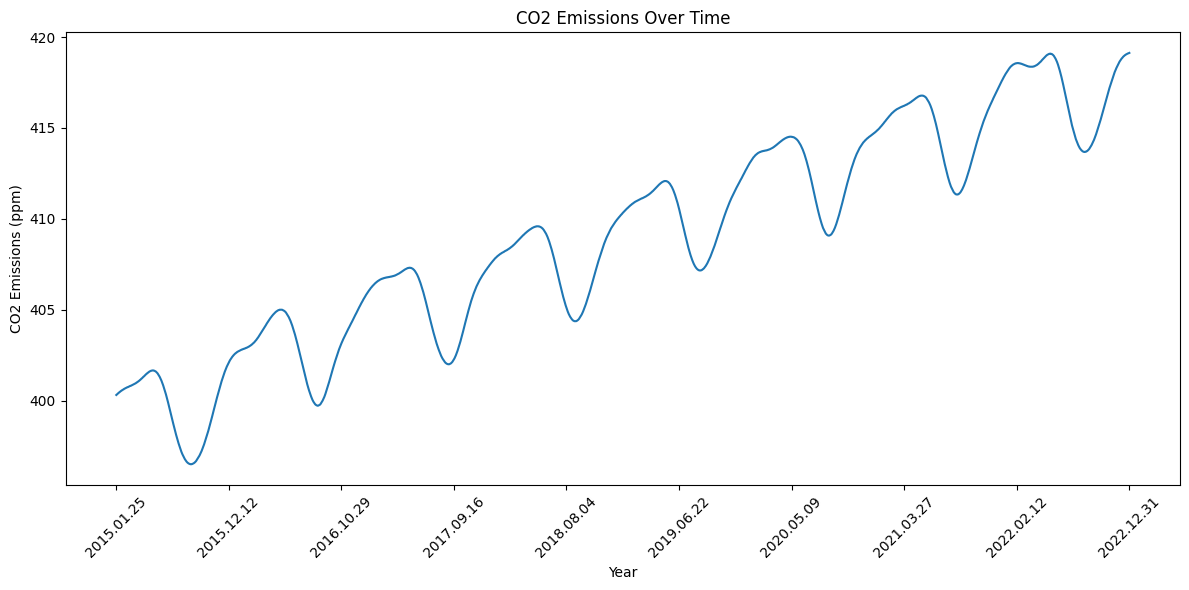

In [36]:
response = local_custom_agent.query(input="what is global co2 decrease?")
response